In [ ]:
from google.colab import userdata
import os

os.environ['KAGGLE_KEY']=userdata.get('KAGGLE_KEY')
os.environ['KAGGLE_USERNAME']=userdata.get('KAGGLE_USERNAME')

In [ ]:
import numpy as np
import cv2
from PIL import Image

In [ ]:
!kaggle datasets download -d sabahesaraki/breast-ultrasound-images-dataset

 98% 191M/195M [00:06<00:00, 33.9MB/s]
100% 195M/195M [00:06<00:00, 29.7MB/s]


In [ ]:
!unzip /content/breast-ultrasound-images-dataset.zip

Archive:  /content/breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflat

In [ ]:
  image_directory = "/content/Dataset_BUSI_with_GT/"


  def load_images(image_folder, label_value):
      images = [img for img in os.listdir(image_directory + image_folder)]
      for image_name in images:
          if image_name.split('.')[1] == 'png' and '_mask' not in image_name:
              image = cv2.imread(image_directory + image_folder + image_name)
              if image is not None:
                  image = Image.fromarray(image, 'RGB')
                  image = image.resize((SIZE, SIZE))
                  image = np.array(image)
                  dataset.append(image)
                  label.append(label_value)

  SIZE = 224
  dataset = []
  label = []


  load_images('benign/', 0)  # Benign class with label 0
  load_images('malignant/', 1)  # Malignant class with label 1
  load_images('normal/', 2)  # Normal class with label 2

  # Convert dataset and label to numpy arrays
  dataset = np.array(dataset)
  label = np.array(label)
  print("Dataset shape:", dataset.shape)
  print("Label shape:", label.shape)

Dataset shape: (780, 224, 224, 3)
Label shape: (780,)


In [ ]:
def custom_preprocessing(image):
    # Apply noise to the image
    noisy_image = add_noise_to_image(image)

    # Apply blur to the image
    blurred_image = apply_blur_to_image(noisy_image)

    # Adjust contrast and brightness
    enhanced_image = adjust_contrast_brightness(blurred_image)

    return enhanced_image

def add_noise_to_image(image):
    # Add noise to the image (customize this function as needed)
    noisy_image = np.clip(image + np.random.normal(loc=0, scale=0.1, size=image.shape), 0, 1)
    return noisy_image


def apply_blur_to_image(image):
    # Apply blur to the image (customize this function as needed)
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    return blurred_image

def adjust_contrast_brightness(image):
    # Adjust contrast and brightness (customize as needed)
    img = (image * 255).astype(np.uint8)  # Convert image to uint8 for PIL
    pil_img = Image.fromarray(img)

    enhancer = ImageEnhance.Contrast(pil_img)
    enhanced_img = enhancer.enhance(1.5)  # Increase contrast by a factor of 1.5

    enhancer = ImageEnhance.Brightness(enhanced_img)
    enhanced_img = enhancer.enhance(1.2)  # Increase brightness by a factor of 1.2

    enhanced_img = np.array(enhanced_img) / 255.0  # Convert back to float32

    return enhanced_img

In [ ]:
import keras
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
num_samples, height, width, channels = dataset.shape
X_flat = dataset.reshape(num_samples, -1)  # Reshape to (samples, height*width*channels)
X_train, X_test, y_train, y_test = train_test_split(X_flat, label, test_size=0.25, random_state=42)
X_train = X_train.reshape(-1, 224, 224, 3)  # Reshape your input data to match the expected input shape

#Applying different augmentation settings to minority classes:
augmentation_class1 = ImageDataGenerator(
    #rescale=1./255,
    rotation_range=5,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    zoom_range=0.1,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,  # No vertical flipping
    preprocessing_function=custom_preprocessing
)

augmentation_class2 = ImageDataGenerator(
    rotation_range=30,  # Rotate images by a maximum of 10 degrees
    width_shift_range=0.2,  # Shift images horizontally by 10% of the width
    height_shift_range=0.2,  # Shift images vertically by 10% of the height
    zoom_range=0.2,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True,
    preprocessing_function=custom_preprocessing

)

#General Augmentation:

datagen = ImageDataGenerator(
    horizontal_flip=True,   # Flip images horizontally
    vertical_flip=True,     # Flip images vertically
    fill_mode='nearest'     # Fill in missing pixels using the nearest available
)


datagen.fit(X_train)
augmented_images = []
augmented_labels = []

# Number of times to augment the data (in this case, we'll double the dataset)
augmentation_factor = 2

for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) >= augmentation_factor:
        break


# Concatenate the augmented data batches
X_train = np.concatenate(augmented_images)
y_train = np.concatenate(augmented_labels)

# Verify the shape of augmented data
print("Shape of augmented images:", X_train.shape)
print("Shape of augmented labels:", y_train.shape)

def apply_augmentation(X_train, y_train):
    if y_train == 1:  # Check for class 1
        return augmentation_class1.random_transform(X_train), y_train
    if y_train == 2:
        return augmentation_class2.random_transform(X_train), y_train
    else:
        return X_train, y_train
X_test= X_test.reshape(-1, 224, 224, 3)  # Reshape your input data to match the expected input shape

Shape of augmented images: (1170, 224, 224, 3)
Shape of augmented labels: (1170,)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler


# Compute class weights
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
# Assign more weight to the second class
class_weights[1] *= 10.0
class_weights[2] *= 4.0
# Create a dictionary of class weights
class_weight = {i: weight for i, weight in enumerate(class_weights)}


INPUT_SHAPE = (224, 224, 3)
inp = keras.layers.Input(shape=INPUT_SHAPE)

### Resnet Model

In [ ]:
model = Sequential()

pretrained_model= keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=3,
                   weights='imagenet')


model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#pretrained_model.trainable=False
for layer in pretrained_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning(I achieved much better results adding this step)
for layer in pretrained_model.layers[-12:]:
    layer.trainable = True


optimizer= Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model.summary())


y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)



94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = 'best_model_weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)
#Fit the model
Resnet = model.fit(np.array(X_train),
                         y_train,
                         batch_size = 32,
                         verbose = 1,
                         epochs = 30,
                         #validation_split = 0.1,
                         validation_data=(X_test, y_test),
                         shuffle = True,
                         class_weight=class_weight,
                         callbacks=[checkpoint]
                         #callbacks=[reduce_lr]
                     )


model.load_weights(checkpoint_path)

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 5.2830 - accuracy: 0.5162
Epoch 1: val_accuracy improved from -inf to 0.67179, saving model to best_model_weights.h5
37/37 [==============================] - 313s 8s/step - loss: 5.2830 - accuracy: 0.5162 - val_loss: 2.3427 - val_accuracy: 0.6718
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 2.3371 - accuracy: 0.6145
Epoch 2: val_accuracy improved from 0.67179 to 0.74359, saving model to best_model_weights.h5
37/37 [==============================] - 295s 8s/step - loss: 2.3371 - accuracy: 0.6145 - val_loss: 1.1037 - val_accuracy: 0.7436
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 1.3626 - accuracy: 0.6615
Epoch 3: val_accuracy improved from 0.74359 to 0.77436, saving model to best_model_weights.h5
37/37 [==============================] - 290s 8s/step - loss: 1.3626 - accuracy: 0.6615 - val_loss: 0.7685 - val_accuracy: 0.7744
Epoch 4/30
37/37 [==============================]



### Evaluating the Model




In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("Test Accuracy:", evaluation[1])
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

7/7 [==============================] - 2s 89ms/step
Test Accuracy: 0.8410256505012512

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       112
           1       0.81      0.75      0.78        51
           2       0.78      0.97      0.86        32

    accuracy                           0.84       195
   macro avg       0.82      0.85      0.83       195
weighted avg       0.84      0.84      0.84       195


Confusion Matrix:
[[95  9  8]
 [12 38  1]
 [ 1  0 31]]


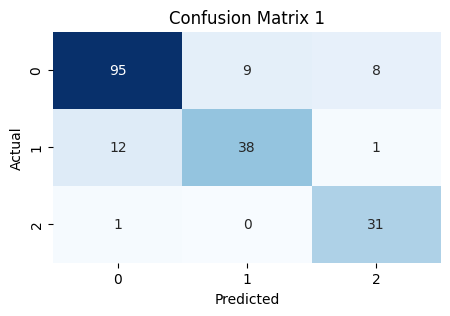

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_mat = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

### EfficientNet

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weight = {i: class_weights[i] for i in range(len(class_weights))}



base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False,
                            input_shape=(224, 224, 3))

# Add custom top layers for your 3-class classification with regularization and dropout
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Freeze layers from the pre-trained model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True


# Compile the model with a lower learning rate and different optimizer
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and the modified architecture
EfficientNet = model.fit(X_train,y_train,class_weight=class_weight, epochs=30,
                    validation_data=(X_test,y_test))

16705208/16705208 [==============================] - 1s 0us/step


Epoch 1/30
37/37 [==============================] - 54s 394ms/step - loss: 5.4772 - accuracy: 0.6658 - val_loss: 4.4248 - val_accuracy: 0.6205
Epoch 2/30
37/37 [==============================] - 10s 272ms/step - loss: 3.0869 - accuracy: 0.8359 - val_loss: 2.7421 - val_accuracy: 0.7949
Epoch 3/30
37/37 [==============================] - 10s 282ms/step - loss: 1.7667 - accuracy: 0.9017 - val_loss: 2.6060 - val_accuracy: 0.7128
Epoch 4/30
37/37 [==============================] - 10s 282ms/step - loss: 0.9902 - accuracy: 0.9538 - val_loss: 1.6563 - val_accuracy: 0.7385
Epoch 5/30
37/37 [==============================] - 10s 273ms/step - loss: 0.7554 - accuracy: 0.8966 - val_loss: 1.4769 - val_accuracy: 0.8051
Epoch 6/30
37/37 [==============================] - 10s 277ms/step - loss: 0.4735 - accuracy: 0.9615 - val_loss: 1.7705 - val_accuracy: 0.6410
Epoch 7/30
37/37 [==============================] - 10s 269ms/step - loss: 0.3757 - accuracy: 0.9556 - val_loss: 0.8469 - val_accuracy: 0.8051



### Evaluating the Model




In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict classes for test data using model.predict
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Generate and print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

7/7 [==============================] - 0s 60ms/step - loss: 0.6917 - accuracy: 0.8513
Test Accuracy: 0.8512820601463318
7/7 [==============================] - 2s 53ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       112
           1       0.76      0.88      0.82        51
           2       0.79      0.94      0.86        32

    accuracy                           0.85       195
   macro avg       0.83      0.88      0.85       195
weighted avg       0.86      0.85      0.85       195

Confusion Matrix:
[[91 13  8]
 [ 6 45  0]
 [ 1  1 30]]


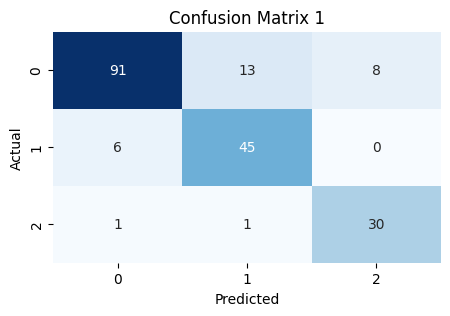

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_mat = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

### MobileNet

In [ ]:
model = Sequential()

pretrained_model= keras.applications.MobileNetV2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=3,
                   weights='imagenet')


model.add(pretrained_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

#pretrained_model.trainable=False
for layer in pretrained_model.layers:
    layer.trainable = False
# Unfreeze the last few layers for fine-tuning(I achieved much better results adding this step)
for layer in pretrained_model.layers[-12:]:
    layer.trainable = True


optimizer= Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model.summary())


y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)



9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               655872    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                         

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = 'best_model_weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)
#Fit the model
MobileNet = model.fit(np.array(X_train),
                         y_train,
                         batch_size = 32,
                         verbose = 1,
                         epochs = 30,
                         #validation_split = 0.1,
                         validation_data=(X_test, y_test),
                         shuffle = True,
                         class_weight=class_weight,
                         callbacks=[checkpoint]
                         #callbacks=[reduce_lr]
                     )


model.load_weights(checkpoint_path)

Epoch 1/30
37/37 [==============================] - ETA: 0s - loss: 1.5640 - accuracy: 0.4342
Epoch 1: val_accuracy improved from -inf to 0.56410, saving model to best_model_weights.h5
37/37 [==============================] - 10s 131ms/step - loss: 1.5640 - accuracy: 0.4342 - val_loss: 1.4602 - val_accuracy: 0.5641
Epoch 2/30
37/37 [==============================] - ETA: 0s - loss: 1.1550 - accuracy: 0.5487
Epoch 2: val_accuracy improved from 0.56410 to 0.57436, saving model to best_model_weights.h5
37/37 [==============================] - 2s 59ms/step - loss: 1.1550 - accuracy: 0.5487 - val_loss: 1.7192 - val_accuracy: 0.5744
Epoch 3/30
37/37 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.5692
Epoch 3: val_accuracy did not improve from 0.57436
37/37 [==============================] - 2s 56ms/step - loss: 0.9964 - accuracy: 0.5692 - val_loss: 1.5472 - val_accuracy: 0.5385
Epoch 4/30
36/37 [============================>.] - ETA: 0s - loss: 0.8026 - accuracy: 0.6



### Evaluating the Model




In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("Test Accuracy:", evaluation[1])
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

7/7 [==============================] - 1s 34ms/step
Test Accuracy: 0.6615384817123413

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.77       112
           1       0.82      0.35      0.49        51
           2       0.40      0.53      0.46        32

    accuracy                           0.66       195
   macro avg       0.65      0.57      0.58       195
weighted avg       0.69      0.66      0.65       195


Confusion Matrix:
[[94  3 15]
 [23 18 10]
 [14  1 17]]


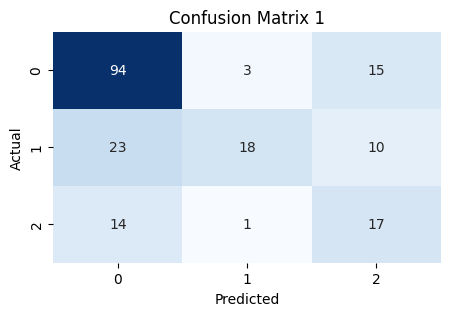

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_mat = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

### GoogleNet

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weight = {i: class_weights[i] for i in range(len(class_weights))}



base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False,
                            input_shape=(224, 224, 3))

# Add custom top layers for your 3-class classification with regularization and dropout
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Freeze layers from the pre-trained model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True


# Compile the model with a lower learning rate and different optimizer
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and the modified architecture
GoogleNet = model.fit(X_train,y_train,class_weight=class_weight, epochs=30,
                    validation_data=(X_test,y_test))

87910968/87910968 [==============================] - 3s 0us/step


Epoch 1/30
37/37 [==============================] - 59s 505ms/step - loss: 5.8367 - accuracy: 0.5120 - val_loss: 23.6373 - val_accuracy: 0.5744
Epoch 2/30
37/37 [==============================] - 10s 263ms/step - loss: 3.3669 - accuracy: 0.6897 - val_loss: 55.7540 - val_accuracy: 0.5692
Epoch 3/30
37/37 [==============================] - 9s 254ms/step - loss: 2.0190 - accuracy: 0.7564 - val_loss: 15.8403 - val_accuracy: 0.5744
Epoch 4/30
37/37 [==============================] - 10s 258ms/step - loss: 1.3716 - accuracy: 0.8385 - val_loss: 11.6352 - val_accuracy: 0.4000
Epoch 5/30
37/37 [==============================] - 9s 252ms/step - loss: 1.0130 - accuracy: 0.8538 - val_loss: 3.1174 - val_accuracy: 0.6462
Epoch 6/30
37/37 [==============================] - 9s 249ms/step - loss: 0.7788 - accuracy: 0.8632 - val_loss: 1.2860 - val_accuracy: 0.6923
Epoch 7/30
37/37 [==============================] - 9s 250ms/step - loss: 0.6283 - accuracy: 0.8966 - val_loss: 3.5699 - val_accuracy: 0.6000



### Evaluating the Model




In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict classes for test data using model.predict
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Generate and print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

7/7 [==============================] - 1s 68ms/step - loss: 1.3439 - accuracy: 0.7692
Test Accuracy: 0.7692307829856873
7/7 [==============================] - 2s 61ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       112
           1       0.93      0.51      0.66        51
           2       0.56      1.00      0.72        32

    accuracy                           0.77       195
   macro avg       0.78      0.78      0.74       195
weighted avg       0.82      0.77      0.77       195

Confusion Matrix:
[[92  2 18]
 [18 26  7]
 [ 0  0 32]]


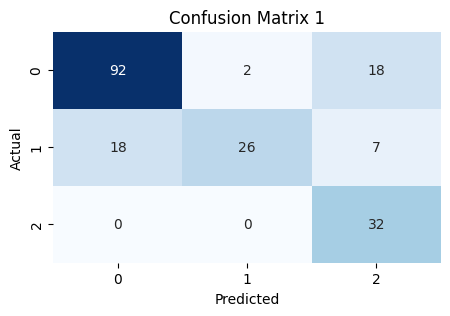

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_mat = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

### VGG Net

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
class_labels = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)
class_weight = {i: class_weights[i] for i in range(len(class_weights))}



base_model = keras.applications.VGG19(weights='imagenet', include_top=False,
                            input_shape=(224, 224, 3))

# Add custom top layers for your 3-class classification with regularization and dropout
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Freeze layers from the pre-trained model
for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
    layer.trainable = True


# Compile the model with a lower learning rate and different optimizer
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation and the modified architecture
VGGnet= model.fit(X_train,y_train,class_weight=class_weight, epochs=30,
                    validation_data=(X_test,y_test))

80134624/80134624 [==============================] - 2s 0us/step


Epoch 1/30
37/37 [==============================] - 59s 916ms/step - loss: 8.0351 - accuracy: 0.3342 - val_loss: 4.0993 - val_accuracy: 0.2615
Epoch 2/30
37/37 [==============================] - 18s 492ms/step - loss: 3.5738 - accuracy: 0.2906 - val_loss: 3.1312 - val_accuracy: 0.5692
Epoch 3/30
37/37 [==============================] - 18s 500ms/step - loss: 2.9083 - accuracy: 0.2060 - val_loss: 2.7121 - val_accuracy: 0.1641
Epoch 4/30
37/37 [==============================] - 19s 508ms/step - loss: 2.5775 - accuracy: 0.2325 - val_loss: 2.4847 - val_accuracy: 0.1641
Epoch 5/30
37/37 [==============================] - 18s 496ms/step - loss: 2.3689 - accuracy: 0.2231 - val_loss: 2.2814 - val_accuracy: 0.1641
Epoch 6/30
37/37 [==============================] - 19s 505ms/step - loss: 2.2156 - accuracy: 0.3197 - val_loss: 2.1487 - val_accuracy: 0.1641
Epoch 7/30
37/37 [==============================] - 18s 500ms/step - loss: 2.0967 - accuracy: 0.3897 - val_loss: 2.0439 - val_accuracy: 0.5692

### Evaluating the Model

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

# Predict classes for test data using model.predict
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Generate and print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

7/7 [==============================] - 1s 125ms/step - loss: 1.3784 - accuracy: 0.5744
Test Accuracy: 0.5743589997291565
7/7 [==============================] - 1s 134ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       112
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        32

    accuracy                           0.57       195
   macro avg       0.19      0.33      0.24       195
weighted avg       0.33      0.57      0.42       195

Confusion Matrix:
[[112   0   0]
 [ 51   0   0]
 [ 32   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


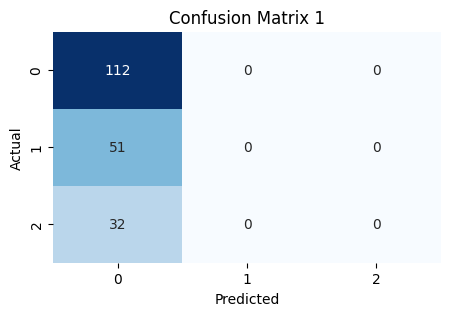

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
confusion_mat = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 3))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix 1')
plt.show()

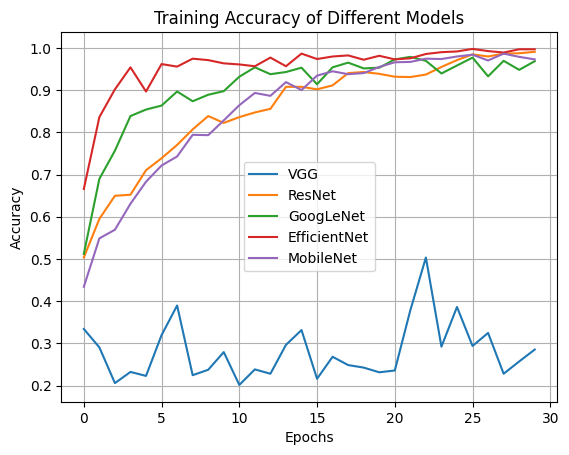

In [ ]:
import matplotlib.pyplot as plt

# Extracting accuracy from the history object of each model
vgg_acc = VGGnet.history['accuracy']
resnet_acc = Resnet.history['accuracy']
googlenet_acc = GoogleNet.history['accuracy']
efficientnet_acc = EfficientNet.history['accuracy']
mobilenet_acc = MobileNet.history['accuracy']

# Plotting accuracy
plt.plot(vgg_acc, label='VGG')
plt.plot(resnet_acc, label='ResNet')
plt.plot(googlenet_acc, label='GoogLeNet')
plt.plot(efficientnet_acc, label='EfficientNet')
plt.plot(mobilenet_acc, label='MobileNet')

plt.title('Training Accuracy of Different Models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV